# Filtering based on mass

In this file we load data which contains all of the points with 2 valid counterfactuals, and select only the ones who have a large enough mass deposition in the cloud. This is done to hopefully strengthen the signal, such that we can out-signal the low SNR. 

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
from datetime import datetime, time, timedelta
from scipy import stats
import matplotlib.pyplot as plt
def sem_statistic(data):
    std_val = np.nanstd(data, ddof=1)
    count = np.sum(~np.isnan(data))
    sem_val = std_val / np.sqrt(count)
    return sem_val
import textwrap

In [2]:
# Loading file paths
data_path = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass")
# Use a nested list comprehension to generate the file paths for each month
Real_files = sorted(list((data_path/"Real").glob("2019_*")))
CFU_files = sorted(list((data_path/"UCF").glob("2019_*")))
CFL_files = sorted(list((data_path/"LCF").glob("2019_*")))
# Flatten the nested lists and concatenate the files
cf_df = pd.concat((pd.read_csv(f) for f in CFU_files + CFL_files), ignore_index=True)
real_df = pd.concat((pd.read_csv(f) for f in Real_files), ignore_index=True)

In [3]:
time_of_obs_real = pd.to_datetime(real_df["jday"], format='mixed')
timestep_real = np.round(real_df["timestep"] * 4) / 4
time_of_emission_real = time_of_obs_real - timestep_real.astype("timedelta64[h]")
# Fitted
time_of_obs_cf = pd.to_datetime(cf_df["jday"], format='mixed')
timestep_cf = np.round(cf_df["timestep"] * 4) / 4
time_of_emission_cf = time_of_obs_cf - timestep_cf.astype("timedelta64[h]")

In [31]:
# Real
wh_valid_real = np.logical_and.reduce([real_df["cer"] > 0, real_df["cer"] < 40, real_df['illum'] !=2, 
                                       real_df["mass"] > 100, real_df["cloud_type"] == 3])
#wh_valid_real = np.logical_and.reduce([real_df["cer_uncertainty"] < 40, real_df["cer"] > 0, real_df["cer"] < 40, real_df["illum"] != 2,
#                                         real_df["cot_uncertainty"] < 10, real_df["cot"] > 0, real_df["cot"] < 30, real_df["cwp_uncertainty"] < 10,
#                                         real_df["cwp"] > 0, real_df["cwp"] < 100, real_df["cloud_type"] == 3, real_df['cth'] > 0.5, real_df['cth'] < 2.5, 
#                                         real_df['cth_uncertainty'] < 2, real_df["timestep"] < 24, real_df["mass"] > 100])
#real_df["Visible_Albedo"] != np.nan, real_df["Albedo_Uncertainty"] != np.nan, real_df["illum"] == 1, 

                                         
# Counterfactuals
wh_valid_cf = np.logical_and.reduce([cf_df["cer"] > 0, cf_df["cer"] < 40, cf_df["illum"] != 2, 
                                     cf_df["mass"] > 100, cf_df["cloud_type"] == 3])
#wh_valid_cf = np.logical_and.reduce([cf_df["cer_uncertainty"] < 40, cf_df["cer"] > 0, cf_df["cer"] < 40, cf_df["illum"] != 2,
#                                        cf_df["cot_uncertainty"] < 10, cf_df["cot"] > 0, cf_df["cot"] < 30, cf_df["cwp_uncertainty"] < 10,
#                                        cf_df["cwp"] > 0, cf_df["cwp"] < 100, cf_df["cloud_type"] == 3, cf_df['cth'] > 0.5, cf_df['cth'] < 2.5, 
#                                        cf_df['cth_uncertainty'] < 2, cf_df["timestep"] < 24, cf_df["mass"] > 100,  cf_df['Distance_to_AIS'] > 15])
#cf_df["illum"] == 1, cf_df["Visible_Albedo"] != np.nan, cf_df["Albedo_Uncertainty"] != np.nan                         


In [32]:
cer_bins_real = stats.binned_statistic_2d(
    time_of_emission_real.dt.hour[wh_valid_real], timestep_real[wh_valid_real], real_df["cer"][wh_valid_real], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)
cot_bins_real = stats.binned_statistic_2d(
    time_of_emission_real.dt.hour[wh_valid_real], timestep_real[wh_valid_real], real_df["cot"][wh_valid_real], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)
cwp_bins_real = stats.binned_statistic_2d(
    time_of_emission_real.dt.hour[wh_valid_real], timestep_real[wh_valid_real], real_df["cwp"][wh_valid_real], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

In [33]:
cer_bins_cf = stats.binned_statistic_2d(
    time_of_emission_cf.dt.hour[wh_valid_cf], timestep_cf[wh_valid_cf], cf_df["cer"][wh_valid_cf], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

cot_bins_cf = stats.binned_statistic_2d(
    time_of_emission_cf.dt.hour[wh_valid_cf], timestep_cf[wh_valid_cf], cf_df["cot"][wh_valid_cf], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

cwp_bins_cf = stats.binned_statistic_2d(
    time_of_emission_cf.dt.hour[wh_valid_cf], timestep_cf[wh_valid_cf], cf_df["cwp"][wh_valid_cf], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

In [34]:
cer_real   = cer_bins_real.statistic
cot_real   = cot_bins_real.statistic
cwp_real   = cwp_bins_real.statistic

cer_cf = cer_bins_cf.statistic
cot_cf = cot_bins_cf.statistic
cwp_cf = cwp_bins_cf.statistic

# np.save("Filtered_Real_cer_array_8hrs", cer_real)
# np.save("Filtered_Real_cot_array_8hrs", cot_real)
# np.save("Filtered_Real_cwp_array_8hrs", cwp_real)

# np.save("Filtered_CF_cer_array_8hrs", cer_real)
# np.save("Filtered_CF_cot_array_8hrs", cot_real)
# np.save("Filtered_CF_cwp_array_8hrs", cwp_real)

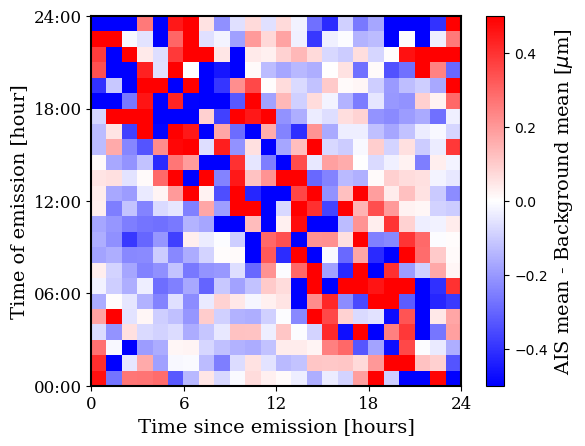

In [35]:
normer = np.ones((24, 24))
signal_cer = cer_real - cer_cf
#MYvmax_cer = np.nanmax(np.abs(signal_cer - normer))
#MYvmin_cer = -MYvmax_cer
plt.figure()
plt.imshow(signal_cer, extent=(0, 24, 24, 0), cmap='bwr', vmin=-0.5, vmax=0.5)  # Adjust vmin and vmax as needed
colorbar = plt.colorbar(label="Difference in mean CER [$\mu$m]")
colorbar.set_label(label="AIS mean - Background mean [$\mu$m]", fontdict={'family': 'serif', 'size': 14})
plt.xticks(np.linspace(0,24,5), font = 'serif', fontsize = 12)
y = np.linspace(0,24,5)
plt.xlabel("Time since emission [hours]", font = 'serif', fontsize = 14)
plt.yticks(y, labels=[f"{int(hour):02d}:00" for hour in y], fontfamily='serif', fontsize=12)
plt.ylabel("Time of emission [hour]", font = 'serif', fontsize = 14)

# title_text = "Deviation of CER From Background vs Time & Time of Emission"
# wrapped_title = "\n".join(textwrap.wrap(title_text, width=30))
# plt.title(wrapped_title, font='serif', fontsize=16)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

plt.gca().invert_yaxis()
plt.savefig('colourbar', bbox_inches='tight', dpi = 400)
plt.show()

In [ ]:
signal_cot = cot_real / cot_cf
MYvmax_cot = np.nanmax(np.abs(signal_cot - normer))
MYvmin_cot = -MYvmax_cot
plt.figure()
plt.imshow(signal_cot - normer, extent=(0, 24, 24, 0), cmap='bwr', vmin=-0.1, vmax=0.1) 
plt.colorbar(label="Fractional Deviation of COT")
plt.xticks(np.linspace(0,24,5))
plt.xlabel("Time since emission [hour]")
plt.yticks(np.linspace(0,24,5))
plt.ylabel("Time of emission [hour]")
plt.gca().invert_yaxis()
plt.title("cot vs time distribution, normalised to background")
#plt.savefig('filtered_cot_2019_heatmap_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

In [ ]:
signal_cwp = cwp_real / cwp_cf
MYvmax_cwp = np.nanmax(np.abs(signal_cwp - normer))
MYvmin_cwp = -MYvmax_cwp
plt.figure()
plt.imshow(signal_cwp - normer, extent=(0, 24, 24, 0), cmap='bwr', vmin=-0.1, vmax=0.1) 
plt.colorbar(label="Fractional Deviation of CWP")
plt.xticks(np.linspace(0,24,5))
plt.xlabel("Time since emission [hour]")
plt.yticks(np.linspace(0,24,5))
plt.ylabel("Time of emission [hour]")
plt.gca().invert_yaxis()
plt.title("cot vs time distribution, normalised to background")
#plt.savefig('filtered_cwp_2019_heatmap_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

In [30]:
cer_bins_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cer"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic = np.nanmean 
)
cer_errors_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cer"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic = sem_statistic
)

cot_bins_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cot"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic=np.nanmean
)
cot_errors_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cot"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic = sem_statistic
)
cwp_bins_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cwp"][wh_valid_real], 
    bins = np.linspace(0,24,25), 
    statistic=np.nanmean
)
cwp_errors_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cwp"][wh_valid_real], 
    bins = np.linspace(0,24,25), 
    statistic = sem_statistic
)

In [31]:
cer_bins_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cer"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic=np.nanmean
)
cer_errors_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cer"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic = sem_statistic
)

cot_bins_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cot"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic=np.nanmean
)
cot_errors_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cot"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic = sem_statistic
)
cwp_bins_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cwp"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic=np.nanmean
)
cwp_errors_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cwp"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic = sem_statistic
)

In [32]:
cer_real_1d   = cer_bins_real_1d.statistic
cot_real_1d   = cot_bins_real_1d.statistic
cwp_real_1d   = cwp_bins_real_1d.statistic
cer_real_errors_1d   = cer_errors_real_1d.statistic
cot_real_errors_1d   = cot_errors_real_1d.statistic
cwp_real_errors_1d   = cwp_errors_real_1d.statistic

cer_cf_1d = cer_bins_cf_1d.statistic
cot_cf_1d = cot_bins_cf_1d.statistic
cwp_cf_1d = cwp_bins_cf_1d.statistic
cer_cf_errors_1d = cer_errors_cf_1d.statistic
cot_cf_errors_1d = cot_errors_cf_1d.statistic
cwp_cf_errors_1d = cwp_errors_cf_1d.statistic

# np.save("filtered_cer_vs_time_real_8hrs", cer_real_1d)
# np.save("filtered_cer_vs_time_errors_real_8hrs", cer_real_errors_1d)
# np.save("filtered_cot_vs_time_real_8hrs", cot_real_1d)
# np.save("filtered_cot_vs_time_errors_real_8hrs", cot_real_errors_1d)
# np.save("filtered_cwp_vs_time_real_8hrs", cwp_real_1d)
# np.save("filtered_cwp_vs_time_errors_real_8hrs", cwp_real_errors_1d)

# np.save("filtered_cer_vs_time_cf_8hrs", cer_cf_1d)
# np.save("filtered_cer_vs_time_errors_cf_8hrs", cer_cf_errors_1d)
# np.save("filtered_cer_vs_time_cf_8hrs", cot_cf_1d)
# np.save("filtered_cer_vs_time_errors_cf_8hrs", cot_cf_errors_1d)
# np.save("filtered_cer_vs_time_cf_8hrs", cwp_cf_1d)
# np.save("filtered_cer_vs_time_errors_cf_8hrs", cwp_cf_errors_1d)

# In[ ]:


# Normalising to signal
cer_signal = (cer_real_1d - cer_cf_1d) 
cwp_signal = (cwp_real_1d - cwp_cf_1d) 
cot_signal = (cot_real_1d - cot_cf_1d) 
# Errors 
cer_error_vector = np.sqrt(cer_real_errors_1d ** 2 + cer_cf_errors_1d ** 2)
cwp_error_vector = np.sqrt(cwp_real_errors_1d ** 2 + cwp_cf_errors_1d ** 2)
cot_error_vector = np.sqrt(cot_real_errors_1d ** 2 + cot_cf_errors_1d ** 2)


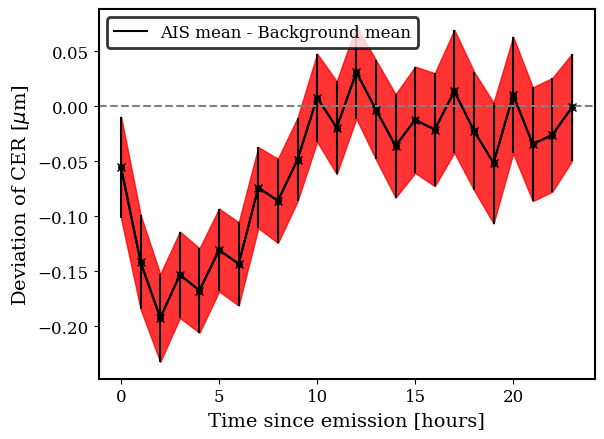

In [34]:
import matplotlib.pyplot as plt

# Your existing plotting code
plt.errorbar(range(len(cer_signal)), cer_signal, yerr=cer_error_vector, fmt='x', color='black')
plt.plot(range(len(cer_signal)), cer_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cer_signal)), cer_signal - cer_error_vector, cer_signal + cer_error_vector, color='red', alpha=0.8)
plt.plot(cer_signal, color='black', label='AIS mean - Background mean')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time since emission [hours]', font='serif', fontsize=14)
plt.ylabel('Deviation of CER [$\mu$m]', font='serif', fontsize=14)
#plt.xticks(fontfamily='serif', fontsize=12)
#y = np.linspace(0,24,5)
plt.xticks(fontfamily='serif', fontsize=12)
plt.yticks(fontfamily='serif', fontsize=12)
legend = plt.legend(loc='upper left', prop={'family': 'serif', 'size': 12}, fontsize=12, bbox_to_anchor=(0, 1))
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(2)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.savefig('1D_CER_V_T', bbox_inches = 'tight', dpi = 400)
plt.show()


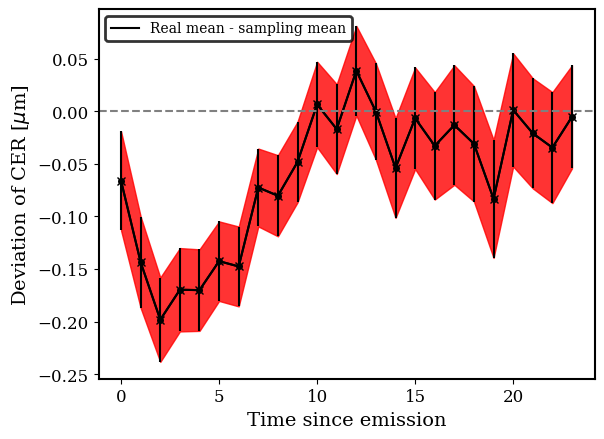

In [40]:
plt.errorbar(range(len(cer_signal)), cer_signal, yerr=cer_error_vector, fmt='x', color='black')#, label='Real points / sampling points')
plt.plot(range(len(cer_signal)), cer_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cer_signal)), cer_signal - cer_error_vector, cer_signal + cer_error_vector, color='red', alpha=0.8)
plt.plot(cer_signal, color='black', label='Real mean - sampling mean')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time since emission', font = 'serif', fontsize=14)
plt.ylabel('Deviation of CER [$\mu$m]', font = 'serif', fontsize=14)
#plt.title('Average Deviation of CER for Mass Filtered Data', font = 'serif')
plt.xticks(font = 'serif', fontsize=12)
plt.yticks(font = 'serif', fontsize=12)
#plt.legend(loc = 'upper left', prop={'family': 'serif'})
legend = plt.legend(loc = 'upper left', prop={'family': 'serif'}, fontsize=22)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(2)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
#plt.savefig('cer_vs_time_mass_filter', bbox_inches='tight', dpi = 400)
plt.show()


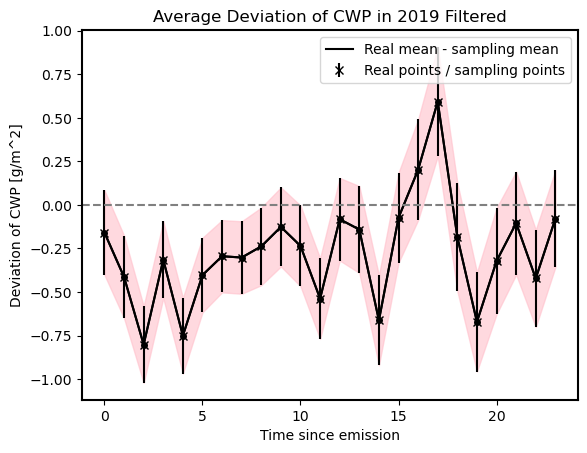

In [31]:
plt.errorbar(range(len(cwp_signal)), cwp_signal, yerr=cwp_error_vector, fmt='x', color='black', label='Real points / sampling points')
plt.plot(range(len(cwp_signal)), cwp_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cwp_signal)), cwp_signal - cwp_error_vector, cwp_signal + cwp_error_vector, color='pink', alpha=0.6)
plt.plot(cwp_signal, color='black', label='Real mean - sampling mean')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time since emission')
plt.ylabel('Deviation of CWP [g/m^2]')
plt.title('Average Deviation of CWP in 2019 Filtered')
legend = plt.legend()
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(2)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
#plt.savefig('cwp_vs_time_filtered_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

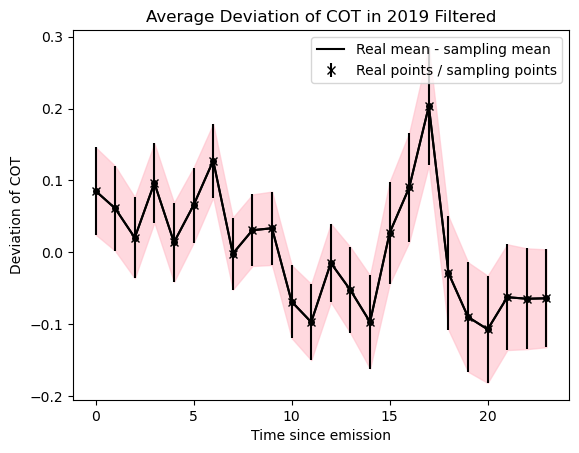

In [19]:
plt.errorbar(range(len(cot_signal)), cot_signal, yerr=cot_error_vector, fmt='x', color='black', label='Real points / sampling points')
plt.plot(range(len(cot_signal)), cot_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cot_signal)), cot_signal - cot_error_vector, cot_signal + cot_error_vector, color='pink', alpha=0.6)
plt.plot(cot_signal, color='black', label='Real mean - sampling mean')
plt.xlabel('Time since emission')
plt.ylabel('Deviation of COT')
plt.title('Average Deviation of COT in 2019 Filtered')
plt.legend()
#plt.savefig('cot_vs_time_filtered_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

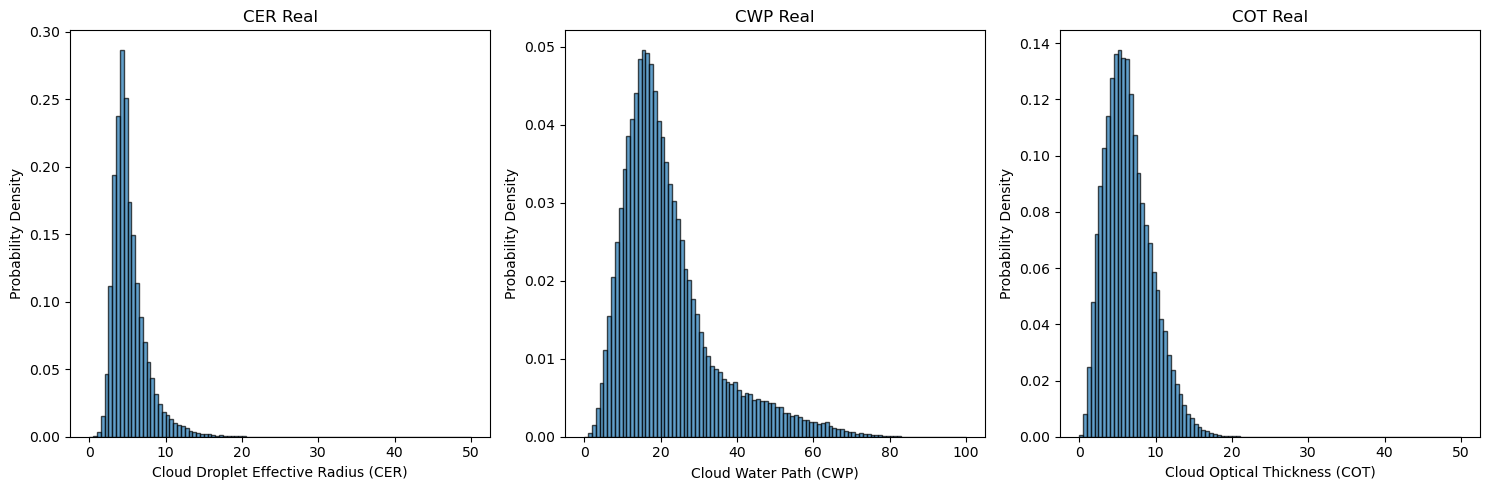

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'cer'
cer_data = real_df["cer"][wh_valid_real]
axs[0].hist(cer_data, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[0].set_title('CER Real')
axs[0].set_xlabel('Cloud Droplet Effective Radius (CER)')
axs[0].set_ylabel('Probability Density')

# Plot for 'cwp'
cwp_data = real_df["cwp"][wh_valid_real]
axs[1].hist(cwp_data, bins=np.linspace(0, 100, 101), density=True, edgecolor='black', alpha=0.7)
axs[1].set_title('CWP Real')
axs[1].set_xlabel('Cloud Water Path (CWP)')
axs[1].set_ylabel('Probability Density')

# Plot for 'cot'
cot_data = real_df["cot"][wh_valid_real]
axs[2].hist(cot_data, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[2].set_title('COT Real')
axs[2].set_xlabel('Cloud Optical Thickness (COT)')
axs[2].set_ylabel('Probability Density')

plt.tight_layout()
#plt.savefig("Real_cloud_properties_2019_filtered_8hrs", bbox_inches = 'tight', dpi = 400) 
plt.show()

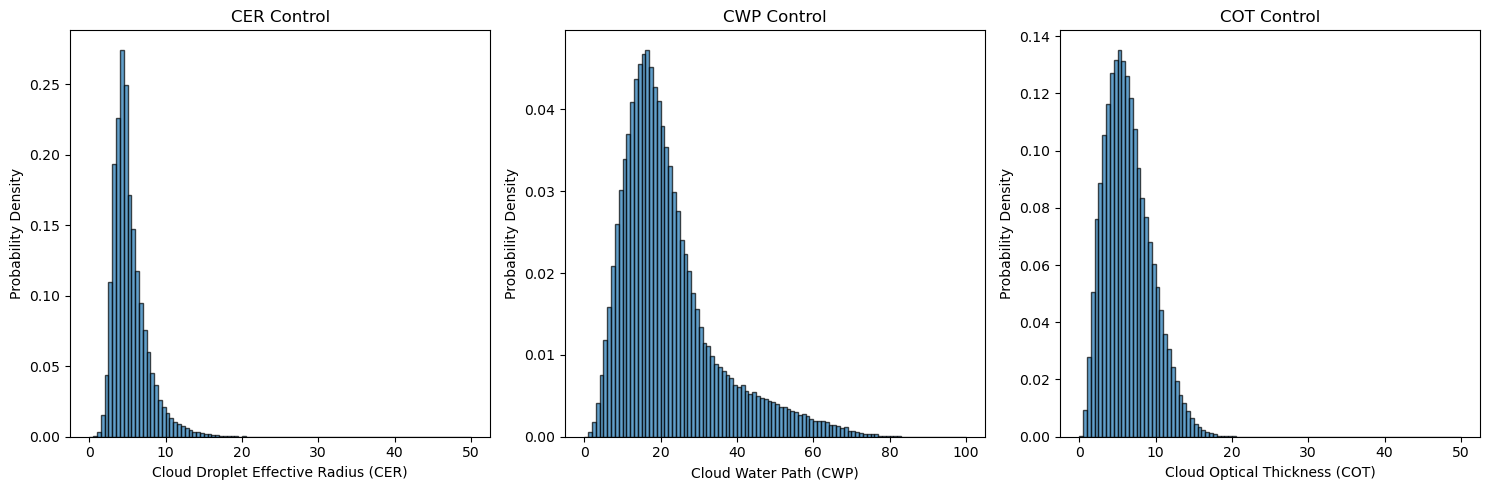

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'cer'
cer_data_cf = cf_df["cer"][wh_valid_cf]
axs[0].hist(cer_data_cf, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[0].set_title('CER Control')
axs[0].set_xlabel('Cloud Droplet Effective Radius (CER)')
axs[0].set_ylabel('Probability Density')

# Plot for 'cwp'
cwp_data_cf = cf_df["cwp"][wh_valid_cf]
axs[1].hist(cwp_data_cf, bins=np.linspace(0, 100, 101), density=True, edgecolor='black', alpha=0.7)
axs[1].set_title('CWP Control')
axs[1].set_xlabel('Cloud Water Path (CWP)')
axs[1].set_ylabel('Probability Density')

# Plot for 'cot'
cot_data_cf = cf_df["cot"][wh_valid_cf]
axs[2].hist(cot_data_cf, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[2].set_title('COT Control')
axs[2].set_xlabel('Cloud Optical Thickness (COT)')
axs[2].set_ylabel('Probability Density')

plt.tight_layout()
#plt.savefig("Sample_cloud_properties_2019_filtered_8hrs", bbox_inches = 'tight', dpi = 400) 
plt.show()

In [22]:
# fig, axs_real = plt.subplots(1, 3, figsize=(15, 5))

# # Plot 'cer' on the existing subplot
# axs_real[0].hist(cer_data, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.5, label='AIS')
# axs_real[0].hist(cer_data_cf, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.5, label='Background')
# axs_real[0].set_title('CER Real vs Background')
# axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]')
# axs_real[0].set_ylabel('Probability Density')
# axs_real[0].legend()

# # Plot 'cwp' on the existing subplot
# axs_real[1].hist(cwp_data, bins=np.linspace(0, 100, 101), density=True, edgecolor='black', alpha=0.5, label='AIS')
# axs_real[1].hist(cwp_data_cf, bins=np.linspace(0, 100, 101), density=True, edgecolor='black', alpha=0.5, label='Background')
# axs_real[1].set_title('CWP Real vs Background')
# axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]')
# axs_real[1].set_ylabel('Probability Density')
# axs_real[1].legend()

# # Plot 'cot' on the existing subplot
# axs_real[2].hist(cot_data, bins=np.linspace(0, 50, 101),  density=True, edgecolor='black', alpha=0.5, label='AIS')
# axs_real[2].hist(cot_data_cf, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.5, label='Background')
# axs_real[2].set_title('COT Real vs Background')
# axs_real[2].set_xlabel('Cloud Optical Thickness (COT)')
# axs_real[2].set_ylabel('Probability Density')
# axs_real[2].legend()

# plt.tight_layout()
# #print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# #plt.savefig("Sample_vs_real_cloud_properties_2019_filtered_8hrs", bbox_inches = 'tight', dpi = 400) 
# plt.show()



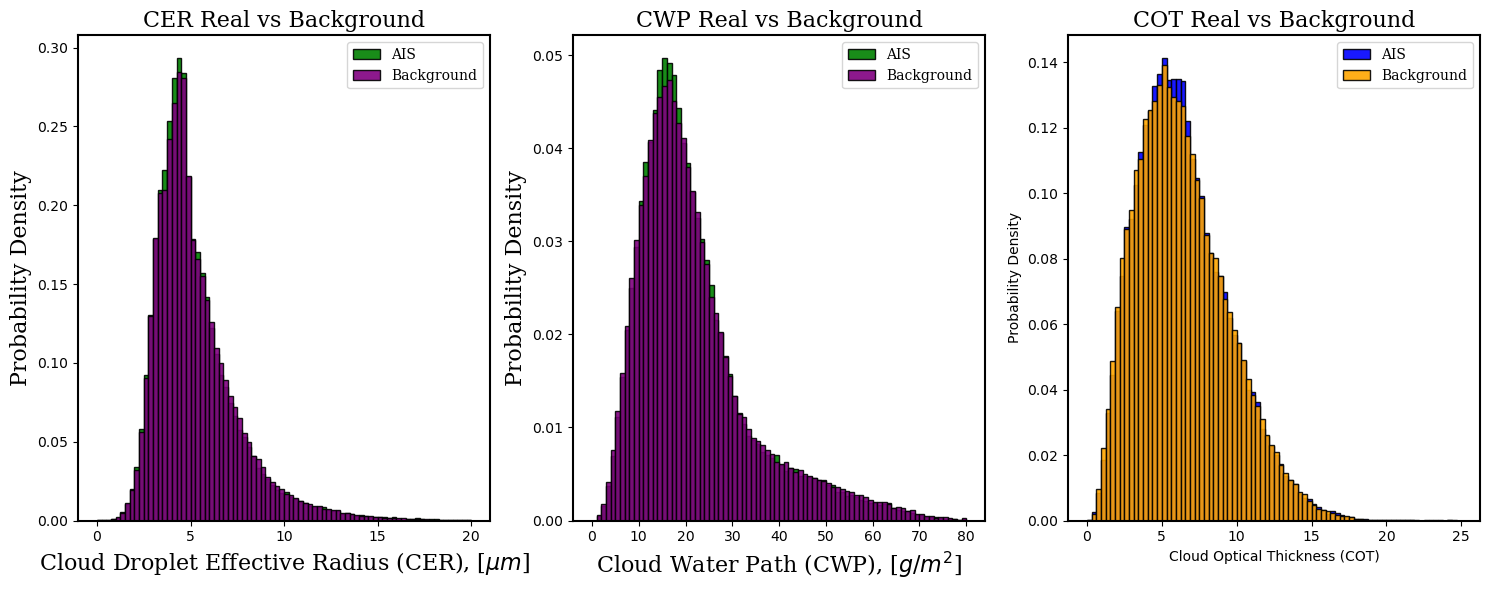

In [23]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs_real = plt.subplots(1, 3, figsize=(15, 6))

# Plot 'cer' on the existing subplot
n_cer, bins_cer, _ = axs_real[0].hist(cer_data, bins=np.linspace(0, 20, 81), density=True, color = 'green', edgecolor='black', alpha=0.9, label='AIS')
n_cer_cf, bins_cer_cf, _ = axs_real[0].hist(cer_data_cf, bins=np.linspace(0, 20, 81), density=True, color = 'purple', edgecolor='black', alpha=0.9, label='Background')
axs_real[0].set_title('CER Real vs Background', fontname = 'serif', fontsize = 16)
axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]', fontname = 'serif', fontsize = 16)
axs_real[0].set_xticks([0, 5, 10, 15, 20], fontname = 'serif', fontsize = 12)
axs_real[0].set_yticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], fontname = 'serif', fontsize = 12, color = 'black')
axs_real[0].set_ylabel('Probability Density', fontname = 'serif', fontsize = 16)
axs_real[0].legend(prop={'family': 'serif'}, fontsize = 12)

# Calculate means and standard deviations for cer_data and cer_data_cf
mean_cer = np.mean(cer_data)
std_cer = np.std(cer_data)
mean_cer_cf = np.mean(cer_data_cf)
std_cer_cf = np.std(cer_data_cf)

# Annotate means and standard deviations on the plot (below the legend)
#axs_real[0].text(0.98, 0.85, f'Mean AIS: {mean_cer:.2f}, Std AIS: {std_cer:.2f}', transform=axs_real[0].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[0].text(0.98, 0.8, f'Mean Background: {mean_cer_cf:.2f}, Std Background: {std_cer_cf:.2f}', transform=axs_real[0].transAxes, verticalalignment='top', horizontalalignment='right')

# Plot 'cwp' on the existing subplot
n_cwp, bins_cwp, _ = axs_real[1].hist(cwp_data, bins=np.linspace(0, 80, 81), density=True, color = 'green', edgecolor='black', alpha=0.9, label='AIS')
n_cwp_cf, bins_cwp_cf, _ = axs_real[1].hist(cwp_data_cf, bins=np.linspace(0, 80, 81), density=True, color = 'purple', edgecolor='black', alpha=0.9, label='Background')
axs_real[1].set_title('CWP Real vs Background', fontname = 'serif', fontsize = 16)
axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]', fontname = 'serif', fontsize = 16)
axs_real[1].set_ylabel('Probability Density', fontname = 'serif', fontsize = 16)
axs_real[1].legend(prop={'family': 'serif'}, fontsize = 12)

# Calculate means and standard deviations for cwp_data and cwp_data_cf
# mean_cwp = np.mean(cwp_data)
# std_cwp = np.std(cwp_data)
# mean_cwp_cf = np.mean(cwp_data_cf)
# std_cwp_cf = np.std(cwp_data_cf)

# Annotate means and standard deviations on the plot (below the legend)
#axs_real[1].text(0.98, 0.85, f'Mean AIS: {mean_cwp:.2f}, Std AIS: {std_cwp:.2f}', transform=axs_real[1].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[1].text(0.98, 0.8, f'Mean Background: {mean_cwp_cf:.2f}, Std Background: {std_cwp_cf:.2f}', transform=axs_real[1].transAxes, verticalalignment='top', horizontalalignment='right')

# Plot 'cot' on the existing subplot
n_cot, bins_cot, _ = axs_real[2].hist(cot_data, bins=np.linspace(0, 25, 81), density=True, color = 'blue',  edgecolor='black', alpha=0.9, label='AIS')
n_cot_cf, bins_cot_cf, _ = axs_real[2].hist(cot_data_cf, bins=np.linspace(0, 25, 81), density=True, color = 'orange', edgecolor='black', alpha=0.9, label='Background')
axs_real[2].set_title('COT Real vs Background', fontname = 'serif', fontsize = 16)
axs_real[2].set_xlabel('Cloud Optical Thickness (COT)')
axs_real[2].set_ylabel('Probability Density')
axs_real[2].legend(prop={'family': 'serif'})

# Calculate means and standard deviations for cot_data and cot_data_cf
# mean_cot = np.mean(cot_data)
# std_cot = np.std(cot_data)
# mean_cot_cf = np.mean(cot_data_cf)
# std_cot_cf = np.std(cot_data_cf)


plt.tight_layout()

#plt.savefig("Sample_vs_real_mass_filtered", bbox_inches = 'tight', dpi = 400) 
for i in range(3):
    axs_real[i].spines['top'].set_linewidth(1.5)
    axs_real[i].spines['right'].set_linewidth(1.5)
    axs_real[i].spines['bottom'].set_linewidth(1.5)
    axs_real[i].spines['left'].set_linewidth(1.5)
plt.show()

#axs_real[0].text(0.98, 0.85, f'Mean AIS: {mean_cer:.2f}, Std AIS: {std_cer:.2f}', transform=axs_real[0].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[0].text(0.98, 0.8, f'Mean Background: {mean_cer_cf:.2f}, Std Background: {std_cer_cf:.2f}', transform=axs_real[0].transAxes, verticalalignment='top', horizontalalignment='right')

#axs_real[1].text(0.98, 0.85, f'Mean AIS: {mean_cwp:.2f}, Std AIS: {std_cwp:.2f}', transform=axs_real[1].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[1].text(0.98, 0.8, f'Mean Background: {mean_cwp_cf:.2f}, Std Background: {std_cwp_cf:.2f}', transform=axs_real[1].transAxes, verticalalignment='top', horizontalalignment='right')

#axs_real[2].text(0.98, 0.85, f'Mean AIS: {mean_cot:.2f}, Std AIS: {std_cot:.2f}', transform=axs_real[2].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[2].text(0.98, 0.8, f'Mean Background: {mean_cot_cf:.2f}, Std Background: {std_cot_cf:.2f}', transform=axs_real[2].transAxes, verticalalignment='top', horizontalalignment='right')


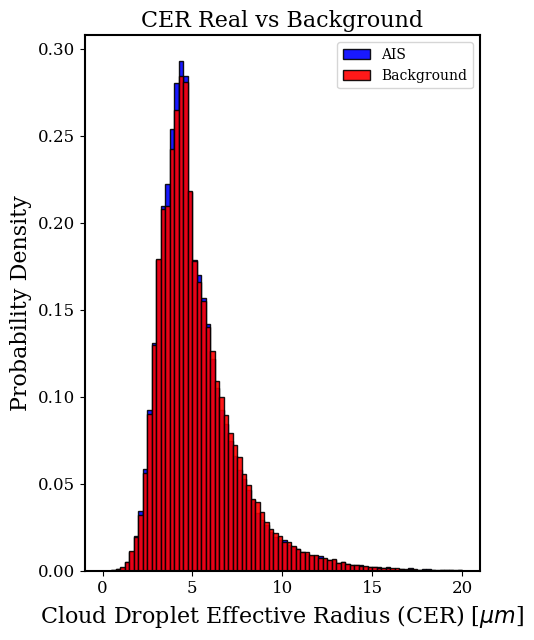

In [24]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 6.5))


n_cer, bins_cer, _ = plt.hist(cer_data, bins=np.linspace(0, 20, 81), density=True, color='blue', edgecolor='black', alpha=0.9, label='AIS')
n_cer_cf, bins_cer_cf, _ = plt.hist(cer_data_cf, bins=np.linspace(0, 20, 81), density=True, color='red', edgecolor='black', alpha=0.9, label='Background')

# Set plot titles and labels
plt.title('CER Real vs Background', fontname = 'serif', fontsize = 16)
plt.xlabel('Cloud Droplet Effective Radius (CER) [$\mu m$]', fontname = 'serif', fontsize = 16)
plt.ylabel('Probability Density', fontname = 'serif', fontsize = 16)
plt.xticks([0, 5, 10, 15, 20], fontname = 'serif', fontsize = 12, color = 'black')
plt.yticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], fontname = 'serif', fontsize = 12, color = 'black')
plt.legend(prop={'family': 'serif'}, fontsize = 16)

plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig('Cer_mass', bbox_inches = 'tight', dpi = 500)
plt.show()


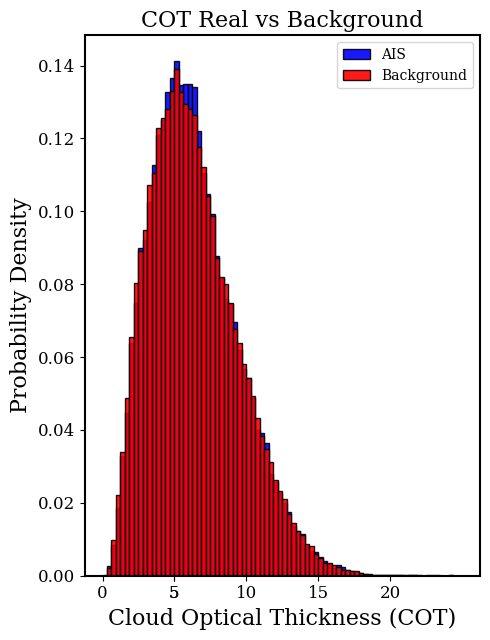

In [25]:
fig = plt.figure(figsize=(5, 6.5))

n_cer, bins_cer, _ = plt.hist(cot_data, bins=np.linspace(0, 25, 81), density=True, color='blue', edgecolor='black', alpha=0.9, label='AIS')
n_cer_cf, bins_cer_cf, _ = plt.hist(cot_data_cf, bins=np.linspace(0, 25, 81), density=True, color='red', edgecolor='black', alpha=0.9, label='Background')

# Set plot titles and labels
plt.title('COT Real vs Background', fontname = 'serif', fontsize = 16)
plt.xlabel('Cloud Optical Thickness (COT)', fontname = 'serif', fontsize = 16)
plt.ylabel('Probability Density', fontname = 'serif', fontsize = 16)
plt.xticks([0, 5, 10, 15, 20, 5], fontname = 'serif', fontsize = 12, color = 'black')
plt.yticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14], fontname = 'serif', fontsize = 12, color = 'black')
plt.legend(prop={'family': 'serif'}, fontsize = 16)

plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.tight_layout()
#plt.savefig('Cer_mass', bbox_inches = 'tight', dpi = 500)
plt.show()


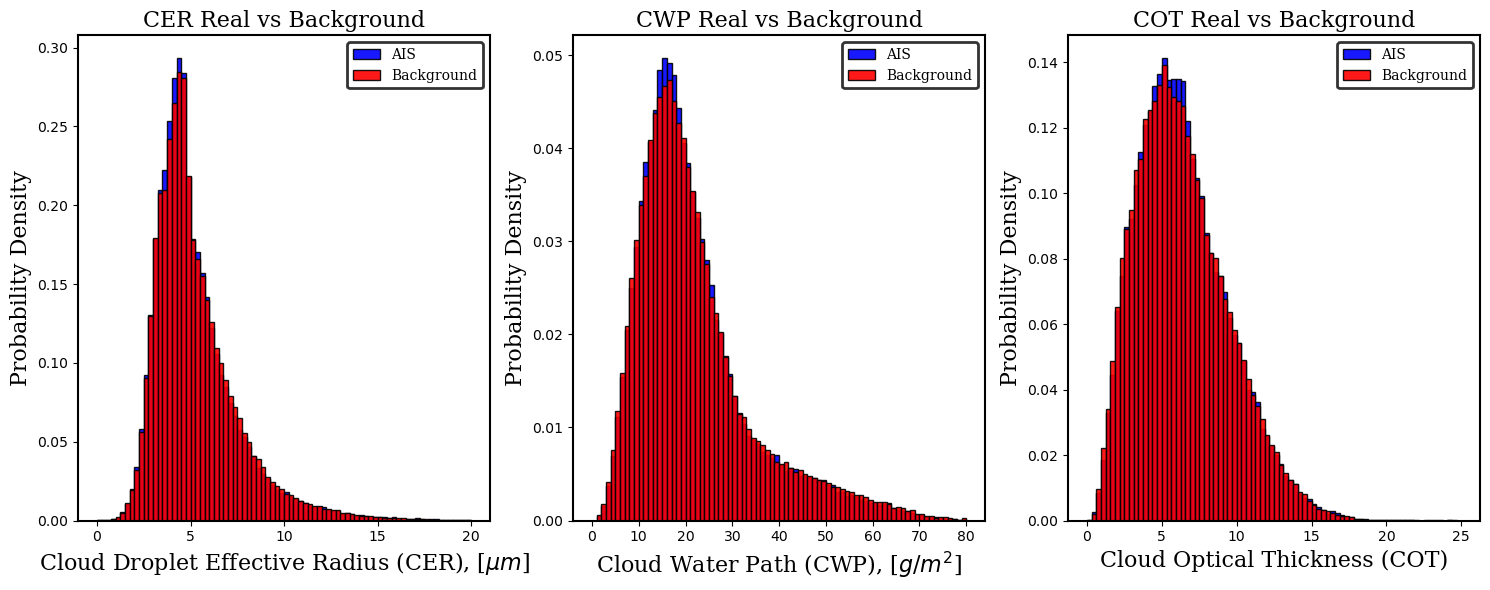

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs_real = plt.subplots(1, 3, figsize=(15, 6))
c1 = 'blue'
c2 = 'red'
# Plot 'cer' on the existing subplot
n_cer, bins_cer, _ = axs_real[0].hist(cer_data, bins=np.linspace(0, 20, 81), density=True, color=c1, edgecolor='black', alpha=0.9, label='AIS')
n_cer_cf, bins_cer_cf, _ = axs_real[0].hist(cer_data_cf, bins=np.linspace(0, 20, 81), density=True, color=c2, edgecolor='black', alpha=0.9, label='Background')
axs_real[0].set_title('CER Real vs Background', fontname='serif', fontsize=16)
axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]', fontname='serif', fontsize=16)
axs_real[0].set_ylabel('Probability Density', fontname='serif', fontsize=16)
axs_real[0].set_xticks([0, 5, 10, 15, 20])
axs_real[0].set_yticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], fontname='serif', fontsize=12, color='black')
legend0 = axs_real[0].legend(prop={'family': 'serif'}, fontsize=12)

# Plot 'cwp' on the existing subplot
n_cwp, bins_cwp, _ = axs_real[1].hist(cwp_data, bins=np.linspace(0, 80, 81), density=True, color=c1, edgecolor='black', alpha=0.9, label='AIS')
n_cwp_cf, bins_cwp_cf, _ = axs_real[1].hist(cwp_data_cf, bins=np.linspace(0, 80, 81), density=True, color=c2, edgecolor='black', alpha=0.9, label='Background')
axs_real[1].set_title('CWP Real vs Background', fontname='serif', fontsize=16)
axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]', fontname='serif', fontsize=16)
axs_real[1].set_ylabel('Probability Density', fontname='serif', fontsize=16)
legend1 = axs_real[1].legend(prop={'family': 'serif'}, fontsize=12)

# Plot 'cot' on the existing subplot
n_cot, bins_cot, _ = axs_real[2].hist(cot_data, bins=np.linspace(0, 25, 81), density=True, color=c1, edgecolor='black', alpha=0.9, label='AIS')
n_cot_cf, bins_cot_cf, _ = axs_real[2].hist(cot_data_cf, bins=np.linspace(0, 25, 81), density=True, color=c2, edgecolor='black', alpha=0.9, label='Background')
axs_real[2].set_title('COT Real vs Background', fontname='serif', fontsize=16)
axs_real[2].set_xlabel('Cloud Optical Thickness (COT)', fontname='serif', fontsize=16)
axs_real[2].set_ylabel('Probability Density', fontname='serif', fontsize=16)
legend2 = axs_real[2].legend(prop={'family': 'serif'}, fontsize=12)

# Adjusting the border thickness for all subplots
for ax in axs_real:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

# Adding a black box around each legend
for legend in [legend0, legend1, legend2]:
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(2)  # Adjust the thickness of the legend box border

plt.tight_layout()
plt.savefig('mass_final', bbox_inches = 'tight', dpi = 500)
plt.show()
